# Make PTEN Figure 1A: Mutation Frequency

This notebook creates a histogram that shows the frequency of different KRAS mutations found across 9 cancers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Step 1: Create dataframe with Mutation Types

For each cancer type, create a data frame that has the mutation type for each sample.

First, load in the cancer data sets from cptac.

In [3]:
en = cptac.Endometrial()
hn = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
c = cptac.Ccrcc()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

In [4]:
cancer = {'Gbm':g, 'Hnscc':hn, 'Luad': l, 'Lscc': ls, 'Brca': b, 'Ov': o, 'Colon': col, 'Endo': en, "Ccrcc": c}
all_df = pd.DataFrame()
for c in cancer:
    test = u.get_frequently_mutated(cancer[c]) #hn, ls, l (KRAS), col  # MUC16, MUC4, CTNNB1
    twenty = test[test['Missense_Mut'] > .2]
    twenty = twenty.assign(cancer = c)
    all_df = all_df.append(twenty)

In [79]:
mis = all_df[['Gene','Missense_Mut','cancer']]
#print(mis.Gene.value_counts())
all_df.loc[all_df['Gene'] == 'MUC16']

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut,Non-Coding,cancer
54,MUC16,0.336364,0.300000,0.072727,NaN,Luad
97,MUC16,0.305556,0.277778,0.027778,NaN,Lscc
242,MUC16,0.364486,0.327103,0.065421,NaN,Colon


In [4]:
mut = col.get_somatic_mutation()
mut.loc[mut['Gene'] == 'KRAS']

Name,Gene,Mutation,Location
Patient_ID,,,
01CO008,KRAS,nonsynonymous SNV,G12V
05CO020,KRAS,nonsynonymous SNV,G12D
05CO026,KRAS,nonsynonymous SNV,Q61H
05CO028,KRAS,nonsynonymous SNV,G12D
05CO033,KRAS,nonsynonymous SNV,G12D
05CO053,KRAS,nonsynonymous SNV,G13D
05CO054,KRAS,nonsynonymous SNV,A146V
09CO005,KRAS,nonsynonymous SNV,G12D
09CO006,KRAS,nonsynonymous SNV,L19F


In [8]:
cancer = {'Gbm':g, 'Hnscc':hn, 'Luad': l, 'Lscc': ls, 'Brca': b, 'Ov': o, 'Colon': col, 'Endo': en}
all_df = pd.DataFrame()
for c_name in cancer:
    test = cancer[c_name].get_somatic_mutation()
    test = test[test['Gene'] == 'KRAS']
    if c_name == 'Colon':
        test = test[test['Mutation'] == 'nonsynonymous SNV']
    else:
        test = test[test['Mutation'] == 'Missense_Mutation']
    test = test.assign(cancer = c_name)
    nt = test.Location.value_counts()
    nt = nt.to_frame()
    nt['Cancer'] = c_name
    all_df = all_df.append(nt)
all_df.loc[all_df['Location'] > 1]

,Location,Cancer
p.G12C,16,Luad
p.G12D,6,Luad
p.G12V,5,Luad
p.G12S,2,Luad
p.G13C,2,Luad
p.G12V,2,Lscc
G12D,11,Colon
G12V,7,Colon
G13D,4,Colon
A146T,3,Colon


In [29]:
cnv = c.get_CNV()
cnv['KRAS']

AttributeError: 'str' object has no attribute 'get_CNV'

Next, call get_geneotype_all_vars for PTEN for each cancer type. This returns a df with columns for Mutation (type of mutation), Location (location of the mutation), and Mutation_Status (wildtype, single, or multiple mutations).  For samples with multiple mutations, a single mutation was reported based on the following priority: deletion, truncation, missense, amplification, inframe, silent, and wildtype. 

In [4]:
gene = "KRAS" 

In [11]:
endo = en.get_genotype_all_vars(gene) 
#gbm = g.get_genotype_all_vars(gene)
#hnscc = hn.get_genotype_all_vars(gene)
ovar = o.get_genotype_all_vars(gene)
#cc = c.get_genotype_all_vars(gene)
colon = col.get_genotype_all_vars(gene)
ld = l.get_genotype_all_vars(gene)
lscc = ls.get_genotype_all_vars(gene)
brca = b.get_genotype_all_vars(gene)

In [12]:
# example
endo.head()

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
C3L-00006,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00008,Missense_Mutation,p.G13D,Multiple_mutation
C3L-00032,Missense_Mutation,p.G12C,Single_mutation
C3L-00090,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00098,Deletion,Deletion,Single_mutation


# Step 2: Match Mutation Labels

The mutation types in the Colon dataset were named differently. We changed these names to match the other cancers. Nonframeshift insertion was changed to match In_Frame_Ins. Frameshift deletion was canged to match Frame_Shift_Del. Nonsynonymous snv represents a missense mutation in this case. 

In [13]:
colon["Mutation"] = colon['Mutation'].replace(['nonsynonymous SNV'], 'Missense')
colon["Mutation"] = colon['Mutation'].replace(['nonframeshift insertion'], 'In_Frame_Ins')
colon["Mutation"] = colon['Mutation'].replace(['frameshift deletion'], 'Frame_Shift_Del')
colon["Mutation"] = colon['Mutation'].replace(['frameshift insertion'], 'Frame_Shift_Ins')


colon.Mutation.value_counts()

Wildtype_Tumor    57
Missense          32
Deletion          10
Amplification      7
Name: Mutation, dtype: int64

We simplified labels for the final figure. We grouped mutations together to create the Indel and Truncation categories. In_Frame_Indel includes: In_Frame_Ins and In_Frame_Del. Truncation includes: Nonsense_Mutation, Frame_Shift_Del, and Frame_Shift_Ins.

In [15]:
# Simplify mutation names, create truncation and indel groups
dfs = [endo, ovar, colon, lscc, ld, brca]
for df in dfs:
    df['Mutation'].where(df['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replace when false
    df['Mutation'].where(df['Mutation'] != 'Wildtype_Tumor', 'Wildtype', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'In_Frame_Del', 'Indel', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'In_Frame_Ins', 'Indel', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Frame_Shift_Del', 'Truncation', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Frame_Shift_Ins', 'Truncation', inplace = True)
    df = df.loc[df['Mutation'] != 'Silent'] # Drop silent
    print(df.Mutation.value_counts())
    

Wildtype         60
Missense         31
Amplification     3
Deletion          1
Name: Mutation, dtype: int64
Wildtype         51
Amplification    37
Deletion         12
Missense          2
Name: Mutation, dtype: int64
Wildtype         57
Missense         32
Deletion         10
Amplification     7
Name: Mutation, dtype: int64
Amplification    63
Wildtype         34
Deletion          6
Missense          5
Name: Mutation, dtype: int64
Wildtype         57
Missense         28
Deletion         14
Amplification    10
Name: Mutation, dtype: int64
Wildtype         91
Amplification    21
Deletion          9
Missense          1
Name: Mutation, dtype: int64


The get_genotype_all_var function created the No_Mutation label when no somatic mutations were found for PTEN in the Luad dataset. This is the same as Wildtype_Tumor. 

In [16]:
ld["Mutation"] = ld['Mutation'].replace(['No_Mutation'], 'Wildtype')

# Step 3: Create Figure

Create a list of the mutation dataframes. Create a list of cancer names for the figure legend. Call the plot_mutations function.

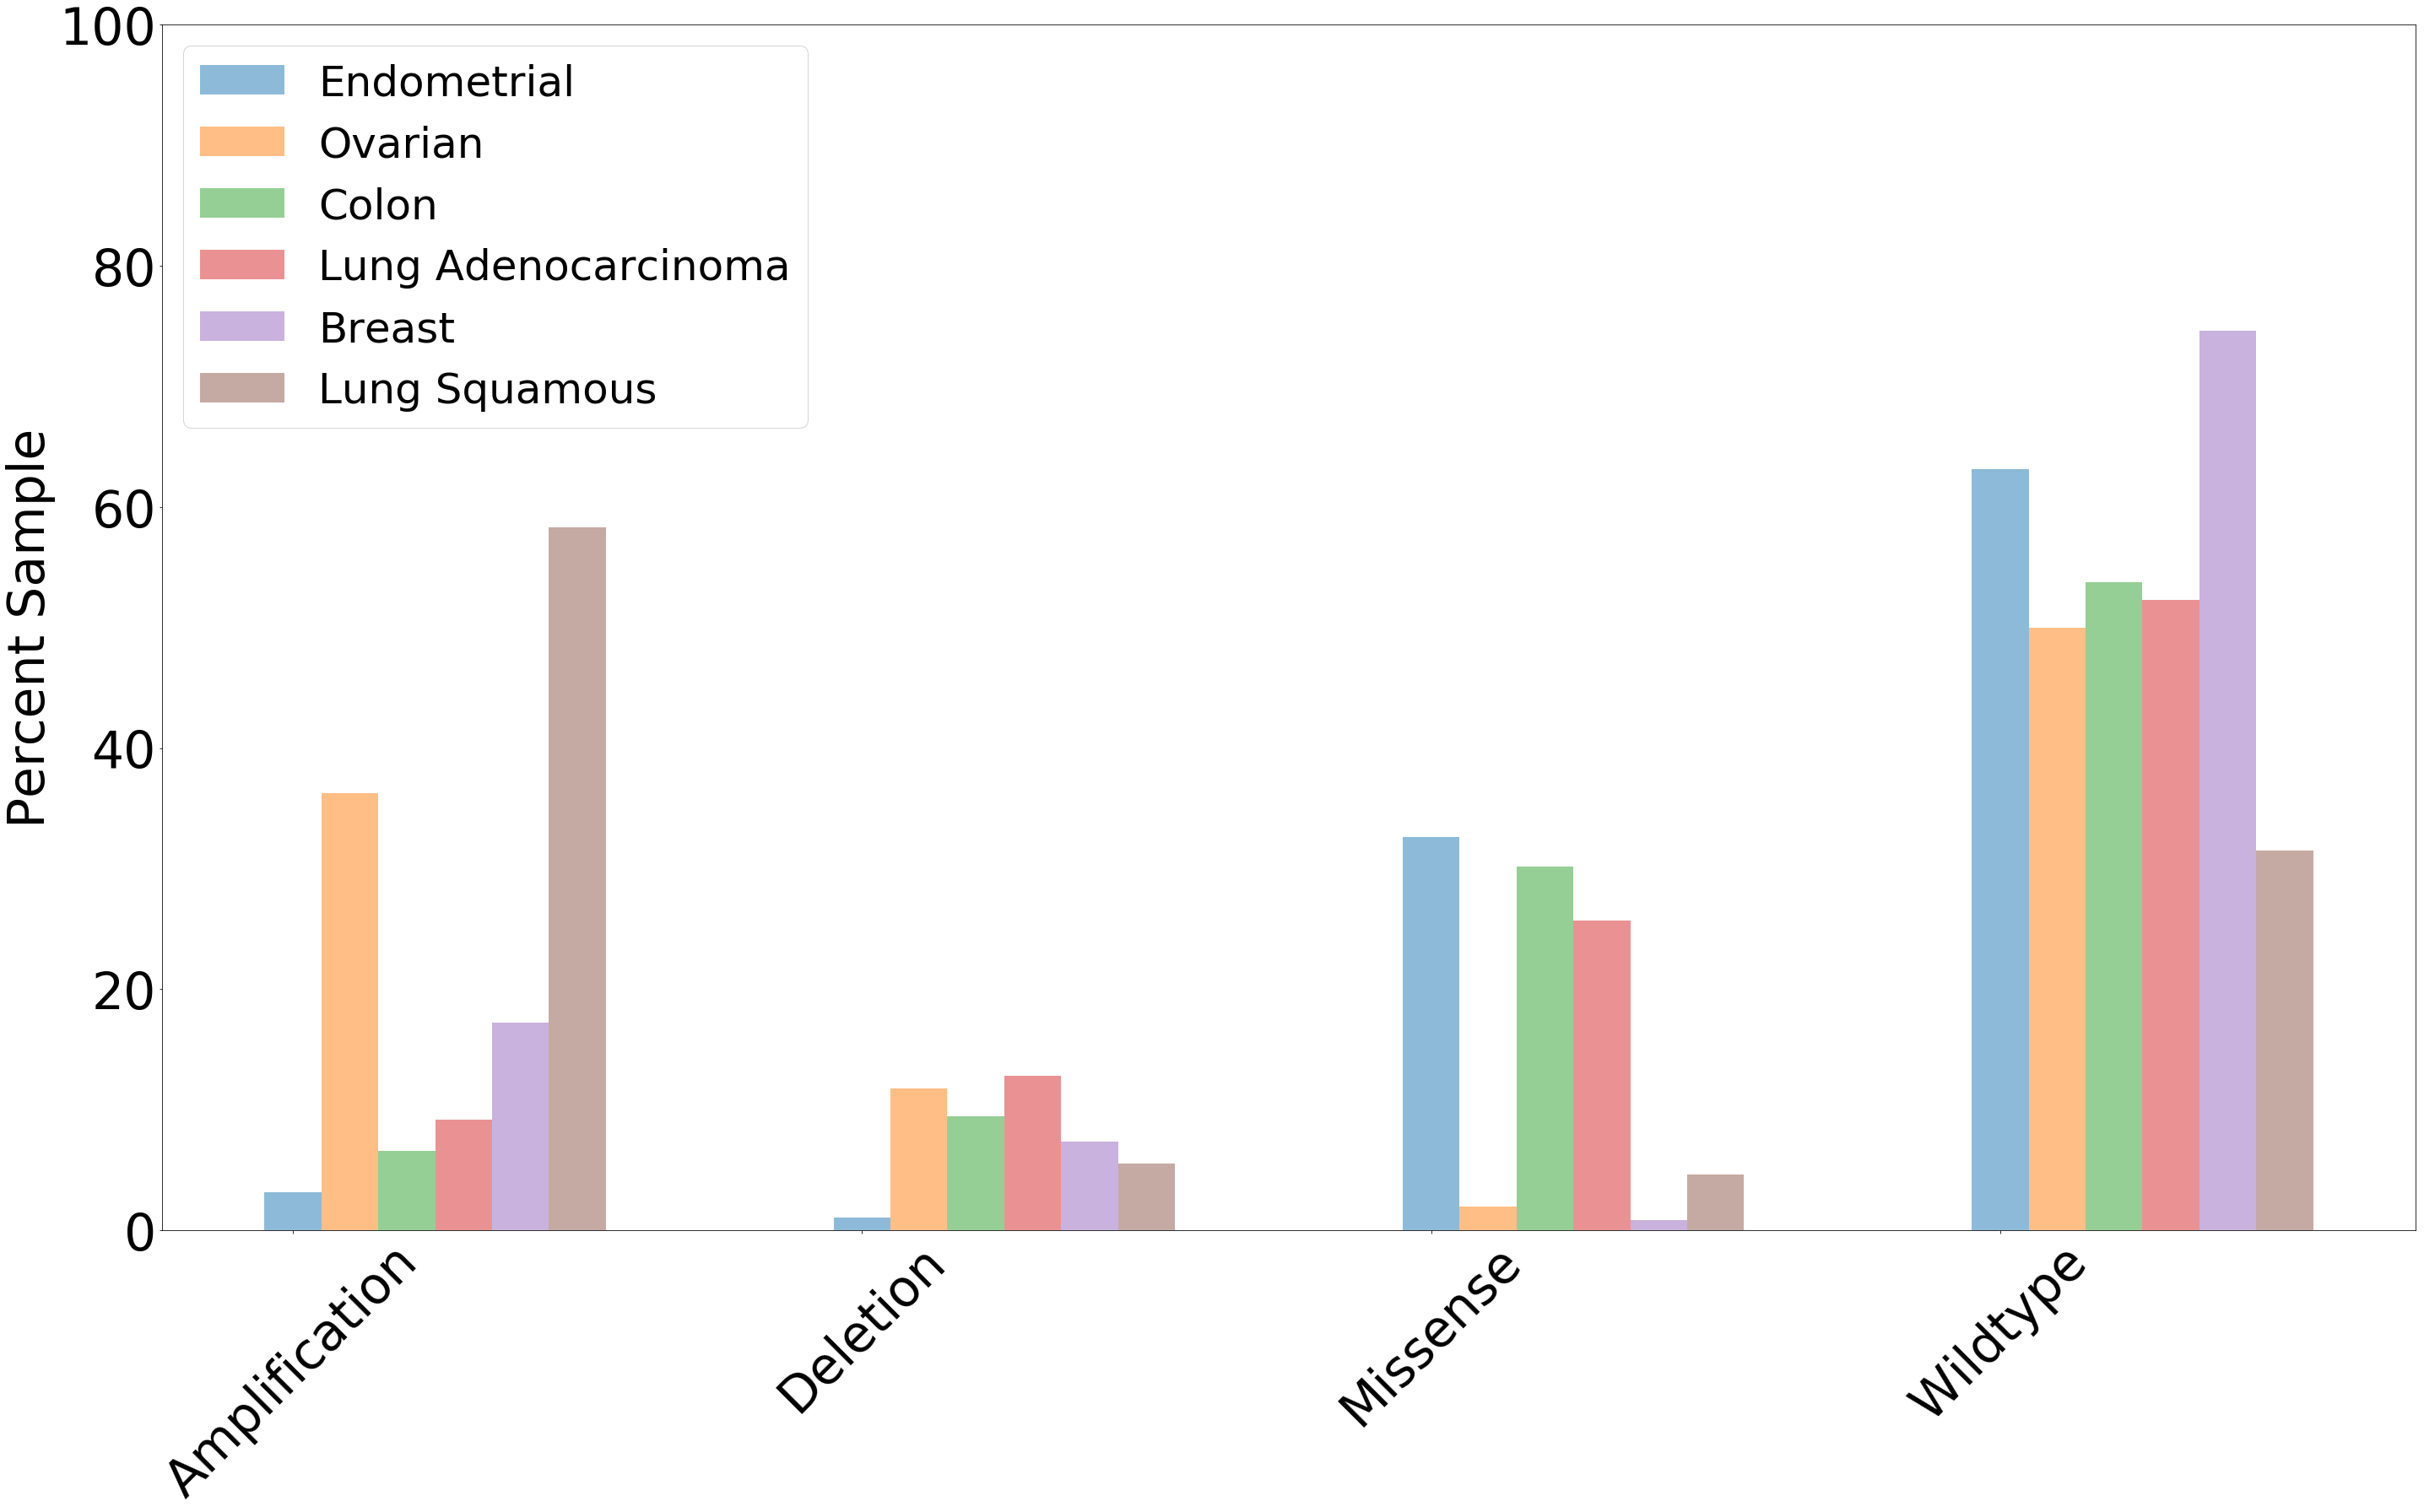

In [19]:
dfs = [endo, ovar, colon, ld, brca, lscc]
for df in dfs:
    df = df.loc[df['Mutation'] != 'Silent']
names = ['Endometrial', 'Ovarian', 'Colon', 'Lung Adenocarcinoma', 'Breast', 'Lung Squamous']

p.figure1_plot_mutations(dfs, names, save_to_path = "Step1_KRAS.png")

# Calculate percentage of missense mutations in tumors

In [ ]:
cancer_dfs = {'Endo':endo, 'Gbm':gbm, 'Hnscc':hnscc, 'Ov':ovar, 'Kidney':cc, 'Colon':colon, 
              'Luad':ld, 'Brca':brca, 'Lscc':lscc}
for cancer in cancer_dfs:
    df = cancer_dfs[cancer]
    vc = df.Mutation.value_counts()
    total = len(df)
    cnv_del = vc.Deletion
    print(cancer)
    print('total_tumor_samples:',total)
    print(cnv_del,'/',total,'=', cnv_del/total,'\n')

# Calculate percentage of PTEN truncation in tumors

The manuscript mentions the exact percentage of PTEN truncation mutations for Endometrial. 

In [ ]:
cancer_dfs = {'Endo':endo}
for cancer in cancer_dfs:
    df = cancer_dfs[cancer]
    vc = df.Mutation.value_counts()
    total = len(df)
    cnv_del = vc.Truncation
    print(cancer)
    print('total_tumor_samples:',total)
    print(cnv_del,'/',total,'=', cnv_del/total,'\n')